In [ ]:
# DETACHED - PREDIKCIA T2/T1 (POMER EFEKTIVNYCH TEPLOT)

In [2]:
# BLOK 1
# Importovanie kniznic.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ast import literal_eval

from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Input, Dense, LSTM, Dropout, Flatten
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
# BLOK 2
# Funkcie pre generovanie sumu. Nastavenie pseudo-nahodneho generatora.

def generate_observation_sigma(space_obs_frac=0.5):
    """
    Draws a standard deviation of noise in light curve points from a "true" value provided in synthetic light curve.
    Noise sigma is drawn from bimodal distribution taking into account contributions from space based and earth based
    observations which have different levels of stochastic noise.

    :param space_obs_frac: ratio between earth based and space based observations
    :return: float; standard deviation of the light curve noise
    """
    earth_based_sigma = 4e-3
    space_based_sigma = 2e-4
    sigma = np.random.choice([earth_based_sigma, space_based_sigma], p=[1-space_obs_frac, space_obs_frac])
    return np.random.rayleigh(sigma)

def stochastic_noise_generator(curve):
    """
    Introduces gaussian noise into synthetic observation provided in `curve`.

    :param curve: numpy.array; normalized light curve
    :return: Tuple(numpy.array, float); normalized light curve with added noise, standard deviation of observations
    """
    sigma = generate_observation_sigma()
    return np.random.normal(curve, sigma), np.full(curve.shape, sigma)

np.random.seed(1234)

In [4]:
# BLOK 3
# Nacitanie syntetickych dat.

data = pd.read_pickle("../detached_one_curve.pkl").reset_index() 

In [5]:
# BLOK 4
# Vyber a priprava dat. Skontrolovanie vyberu podla filtrov.

data_sample=data.sample(n=100000)
data_sample["t2/t1"]=data_sample["secondary__t_eff"]/data["primary__t_eff"]

y=np.array(data_sample["t2/t1"])
X=[]
for row in data_sample["curve"]:
    X.append(row)
X=np.array(X)

print(data_sample["filter"].value_counts())

SLOAN_r      7821
SLOAN_g      7746
TESS         7728
Bessell_R    7726
Bessell_I    7717
SLOAN_z      7713
GaiaDR2      7687
Bessell_V    7678
Bessell_U    7674
Bessell_B    7672
Kepler       7660
SLOAN_i      7601
SLOAN_u      7577
Name: filter, dtype: int64


In [6]:
# BLOK 5
# Rozdelenie dat na trenovaciu a testovaciu mnozinu v pomere 80:20. Pridanie umeleho sumu.

X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2)

X_train=[]
y_train=[]
for i in range(len(X_train1)):
    for j in range(3):
        curve=stochastic_noise_generator(X_train1[i])
        X_train.append(curve[0])
        y_train.append(y_train1[i])
        j+=1        
X_train=np.array(X_train)
y_train=np.array(y_train)

X_test_n=[]
y_test_n=[]
for i in range(len(X_test)):
    for j in range(3):
        curve=stochastic_noise_generator(X_test[i])
        X_test_n.append(curve[0])
        y_test_n.append(y_test[i])
        j+=1
X_test_n=np.array(X_test_n)
y_test_n=np.array(y_test_n)

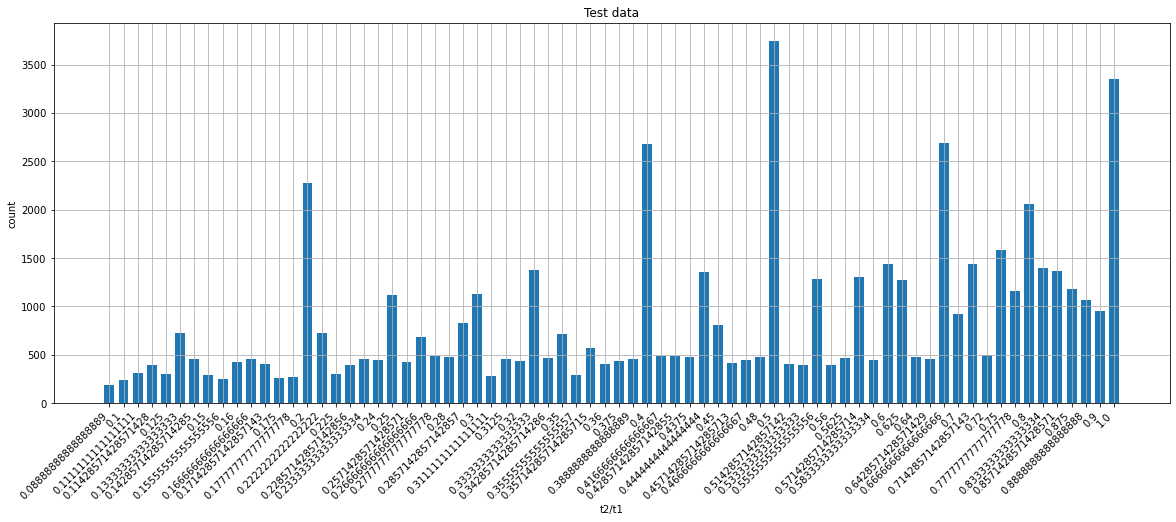

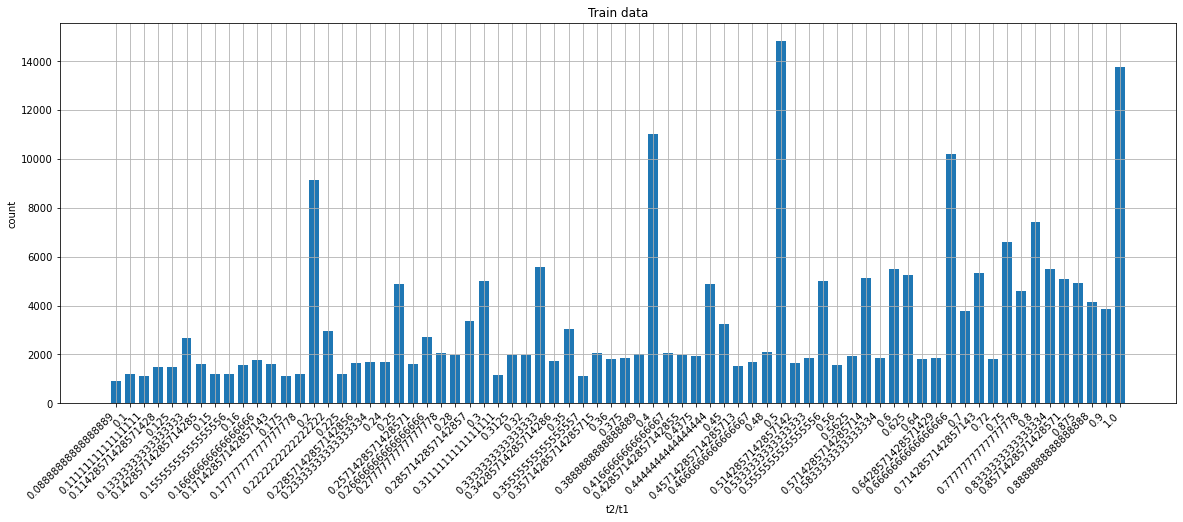

In [7]:
# BLOK 6
# Vykreslenie grafov distribucie hodnot trenovacej a testovacej mnoziny.

y1,y2=np.unique(y_test_n, return_counts=True)
y3,y4=np.unique(y_train, return_counts=True)
y12=pd.DataFrame(data={"value": y1, "count": y2})
y34=pd.DataFrame(data={"value": y3, "count": y4})

fig = plt.figure(figsize=(20,7))
plt.bar(y12["value"].array.astype(str), y12["count"], width=0.7)
plt.xticks(rotation=45, ha='right')
plt.title("Test data")
plt.xlabel("t2/t1")
plt.ylabel("count")
plt.grid(b="on")
plt.show()

fig = plt.figure(figsize=(20,7))
plt.bar(y34["value"].array.astype(str), y34["count"], width=0.7)
plt.xticks(rotation=45, ha='right')
plt.title("Train data")
plt.xlabel("t2/t1")
plt.ylabel("count")
plt.grid(b="on")
plt.show()

In [8]:
# BLOK 7
# Vytvorenie architektury modelu na predikciu t2/t1. Vypis architektury modelu. Spustenie trenovania.

inputs = Input(shape=(400,1))
b = Conv1D(64, kernel_size = 3, padding = "valid")(inputs)
b = MaxPooling1D(2)(b)
b = Dropout(0.2)(b)
b = LSTM(64, return_sequences=True)(b)
b = Flatten()(b)
b = Dense(64, activation='relu')(b)
x = Dense(32, activation='relu')(b)
output = Dense(1, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
print(model.summary())

saved_model = "detached_sT_pT.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

history=model.fit(X_train, y_train, validation_split=0.1, epochs=250, verbose=1, callbacks = callbacks_list, batch_size=64)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 398, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 199, 64)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 199, 64)           0         
                                                                 
 lstm (LSTM)                 (None, 199, 64)           33024     
                                                                 
 flatten (Flatten)           (None, 12736)             0         
                                                             

In [7]:
# BLOK 8
# Nacitanie a vyhodnotenie modelu na testovacich datach.

model=load_model("detached_sT_pT.hdf5")
model.evaluate(X_test_n, y_test_n)

1875/1875 [==============================] - 58s 31ms/step - loss: 0.0082 - mae: 0.0608 - mape: 16.0284


[0.008152120746672153, 0.06075451150536537, 16.028430938720703]

In [9]:
# BLOK 9
# Vysledky predikcie na testovacich krivkach.

y_pred_n=model.predict(X_test_n)
y_pred_n=np.reshape(y_pred_n, len(y_pred_n))
df_n=pd.DataFrame(data={'y_test_n': y_test_n, 'y_predict_n': y_pred_n})
df_n["diff"]=df_n["y_test_n"]-df_n["y_predict_n"]
df_n["abs_diff"]=abs(df_n["diff"])
df_n["re"]=df_n["abs_diff"]/df_n["y_test_n"]

print("pocet kriviek s relativnou chybou < 5%: " + str(len(df_n[df_n["re"]<0.05])) +
      "\npocet kriviek s relativnou chybou < 2,5%: " + str(len(df_n[df_n["re"]<0.025])) +
      "\npocet kriviek s relativnou chybou < 1%: " + str(len(df_n[df_n["re"]<0.01])) +
      "\npocet kriviek s relativnou chybou < 10%: " + str(len(df_n[df_n["re"]<0.1])))

pocet kriviek s relativnou chybou < 5%: 20179
pocet kriviek s relativnou chybou < 2,5%: 11317
pocet kriviek s relativnou chybou < 1%: 4321
pocet kriviek s relativnou chybou < 10%: 32694


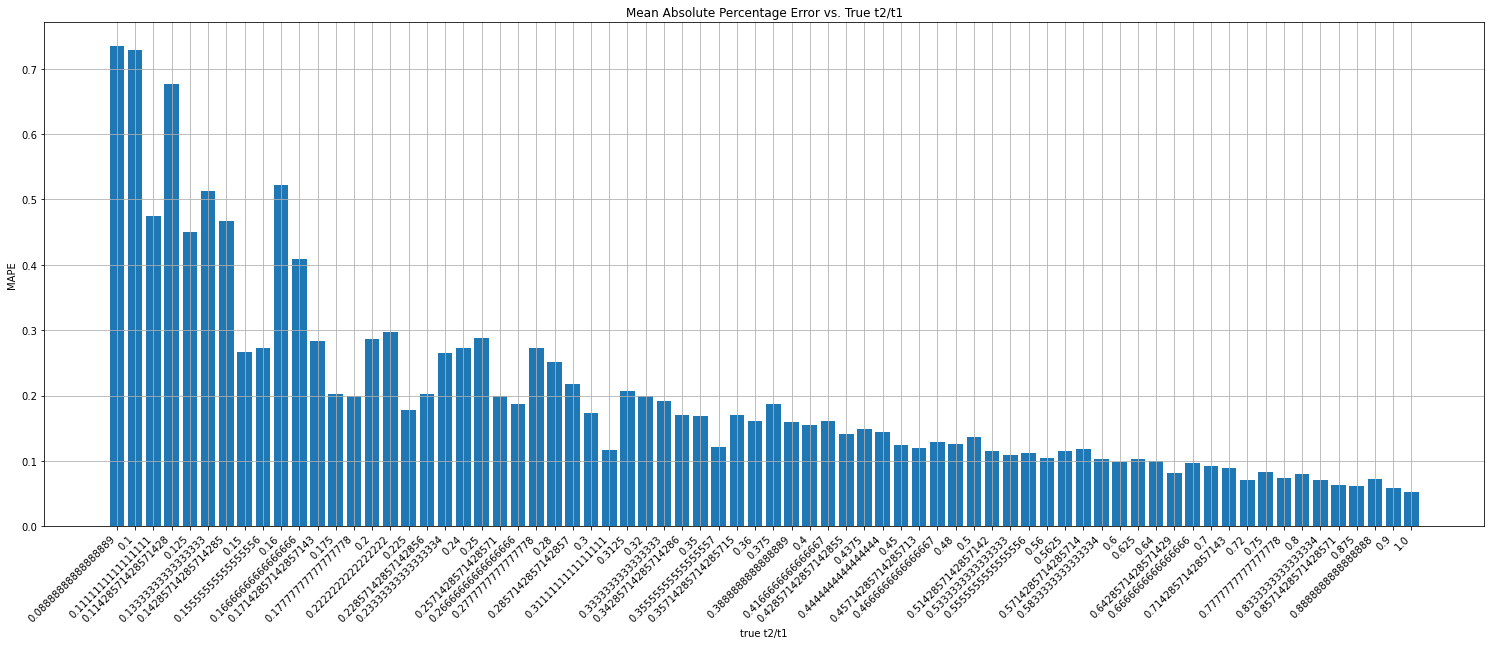

In [10]:
# BLOK 10
# Graficke znazornenie priemernych relativnych chyb podla jednotlivych hodnot pomerov.

df_mean=df_n.groupby(["y_test_n"])
df_mean=pd.DataFrame(df_mean.re.mean()).reset_index()
a_n=df_mean.y_test_n.array.astype(str)
b_n=df_mean.re.array

fig = plt.figure(figsize=(20,7))
ax = fig.add_axes([0,0,1,1])
true = a_n
mean = b_n
ax.bar(true, mean)
ax.set_ylabel("MAPE")
ax.set_xlabel("true t2/t1")
ax.set_title("Mean Absolute Percentage Error vs. True t2/t1")
plt.xticks(rotation=45, ha='right')
plt.grid(b="on")

plt.show()

In [8]:
# BLOK 11
# Nacitanie a priprava observacnych dat.

obs=pd.read_csv("observed.csv")
obs["t2/t1"]=obs["T2"]/obs["T1"]
obs=obs[["name", "filter", "Spot", "t2/t1", "curve", "Type"]]
obs=obs.loc[obs.Type.isin(["detached", "detected"])]
X_o=[]
for row in obs["curve"]:
    processed_data=literal_eval(row)
    X_o.append(processed_data)
X_o=np.array(X_o, dtype=np.float32)

In [9]:
# BLOK 12
# Predikcia a zhodnotenie modelu na observacnych datach.

obs_pred=model.predict(X_o)
model.evaluate(X_o,obs["t2/t1"])

2/2 [==============================] - 1s 20ms/step - loss: 0.0583 - mae: 0.1620 - mape: 23.6254


[0.05833836644887924, 0.16200996935367584, 23.62542724609375]

In [10]:
# BLOK 13
# Vysledky predikcie na observacnych krivkach.

y_pred_o=np.reshape(obs_pred, len(obs_pred))
df_o = {"validation": obs["t2/t1"], "predict": y_pred_o, "name": obs["name"], "filter": obs["filter"], "spot": obs["Spot"]}
df_o = pd.DataFrame(data=df_o)
df_o["diff"]=df_o["validation"]-df_o["predict"]
df_o["abs_diff"]=abs(df_o["diff"])
df_o["re"]=df_o["abs_diff"]/df_o["validation"]

print("pocet observacnych kriviek s relativnou chybou < 5%: " + str(len(df_o[df_o["re"]<0.05])) +
      "\npocet observacnych kriviek s relativnou chybou < 2,5%: " + str(len(df_o[df_o["re"]<0.025])) +
      "\npocet observacnych kriviek s relativnou chybou < 1%: " + str(len(df_o[df_o["re"]<0.01])) +
      "\npocet observacnych kriviek s relativnou chybou < 10%: " + str(len(df_o[df_o["re"]<0.1])))

pocet observacnych kriviek s relativnou chybou < 5%: 10
pocet observacnych kriviek s relativnou chybou < 2,5%: 7
pocet observacnych kriviek s relativnou chybou < 1%: 2
pocet observacnych kriviek s relativnou chybou < 10%: 12


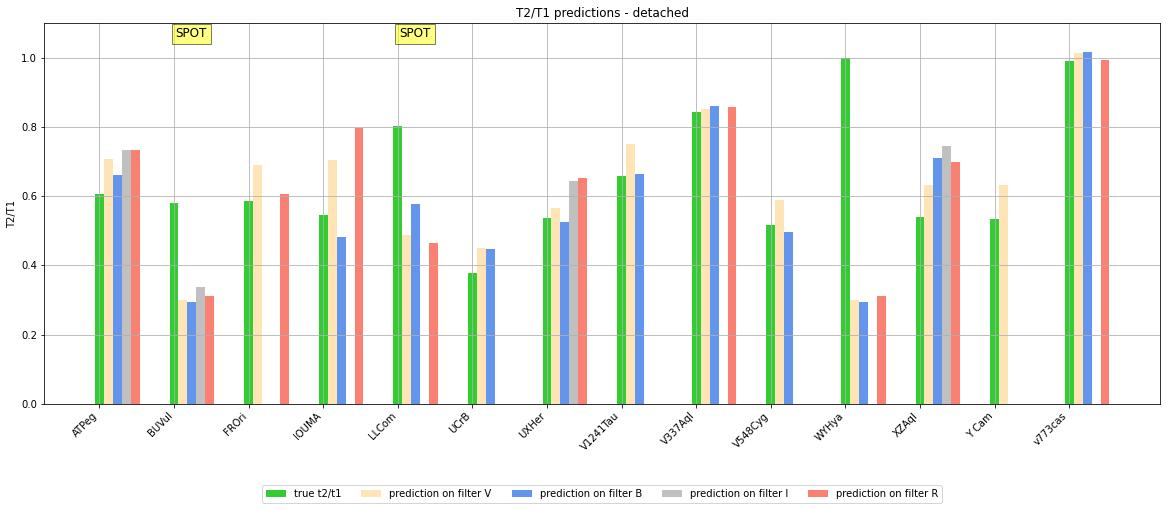

In [11]:
# BLOK 14
# Vykreslenie predikcii na observacnych datach.

def autolabel(rects, pos):
    n=0
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2. +0.23 , pos,
                s=spot.spot[n],
                ha='center', va='bottom', fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))
        n=n+1
spot=df_o[["name", "spot"]].drop_duplicates().reset_index()
spot.spot=spot.spot.map({"N":"", "Y":"SPOT", "y":"SPOT"})
true_t2_t1=df_o[["validation", "name"]].groupby(["name"]).mean()
names=pd.DataFrame(data={"name":true_t2_t1.index})                #názvy systémov hviezd
t2_t1_B=pd.merge(names, df_o[df_o["filter"]=="B"][["predict", "name"]], how="left")
t2_t1_V=pd.merge(names, df_o[df_o["filter"]=="V"][["predict", "name"]], how="left")
t2_t1_R=pd.merge(names, df_o[df_o["filter"]=="R"][["predict", "name"]], how="left")
t2_t1_I=pd.merge(names, df_o[df_o["filter"]=="I"][["predict", "name"]], how="left")

fig, ax = plt.subplots(figsize=(20,7))

barWidth = 0.12
br1 = np.arange(len(names))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]

r=ax.bar(br1, true_t2_t1.validation, barWidth, label='true t2/t1', color="limegreen")
ax.bar(br2, t2_t1_V.predict, barWidth, label='prediction on filter V', color="moccasin")
ax.bar(br3, t2_t1_B.predict, barWidth, label='prediction on filter B', color="cornflowerblue")
ax.bar(br4, t2_t1_I.predict, barWidth, label='prediction on filter I', color="silver")
ax.bar(br5, t2_t1_R.predict, barWidth, label='prediction on filter R', color="salmon")

plt.title("T2/T1 predictions - detached")
plt.xticks(br1, true_t2_t1.index, rotation=45, ha='right')
plt.ylabel("T2/T1")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=5)

plt.grid(b="on")
plt.ylim(top=1.1)
autolabel(r, 1.05)
plt.show()